In [127]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import optuna


In [128]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet')

# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

# Drop columns
A = A.drop(columns=['date_calc','ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3', 'snow_drift:idx'])
B = B.drop(columns=['date_calc','ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3', 'snow_drift:idx'])
C = C.drop(columns=['date_calc','ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3', 'snow_drift:idx'])


test_A = test_A.drop(columns=['date_calc'])
test_B = test_B.drop(columns=['date_calc'])
test_C = test_C.drop(columns=['date_calc'])




#Data splits for testing
# train_A, test_A = train_test_split(A, test_size=0.2, shuffle=True, random_state=42)
# X_train_A = train_A.drop(columns='pv_measurement')
# y_train_A = train_A['pv_measurement']
# X_test_A = test_A.drop(columns='pv_measurement')
# y_test_A = test_A['pv_measurement']


# train_B, test_B = train_test_split(B, test_size=0.2, shuffle=True, random_state=42)
# X_train_B = train_B.drop(columns='pv_measurement')
# y_train_B = train_B['pv_measurement']
# X_test_B = test_B.drop(columns='pv_measurement')
# y_test_B = test_B['pv_measurement']

# train_C, test_C = train_test_split(C, test_size=0.2, shuffle=True, random_state=42)
# X_train_C = train_C.drop(columns='pv_measurement')
# y_train_C = train_C['pv_measurement']
# X_test_C = test_C.drop(columns='pv_measurement')
# y_test_C = test_C['pv_measurement']



# Split target and features
# obs_A_y = obs_A['pv_measurement']
# obs_B_y = obs_B['pv_measurement']
# obs_C_y = obs_C['pv_measurement']
# est_A_y = est_A['pv_measurement']
# est_B_y = est_B['pv_measurement']
# est_C_y = est_C['pv_measurement']
#test_A_y = test_A['pv_measurement']
#test_B_y = test_B['pv_measurement']
#test_C_y = test_C['pv_measurement']
#est_A.info()
#obs_A.info()

# est_A = est_A.drop(columns=['pv_measurement'])
# est_B = est_B.drop(columns='pv_measurement')
# est_C = est_C.drop(columns='pv_measurement')

# obs_A = obs_A.drop(columns='pv_measurement')
# obs_B = obs_B.drop(columns='pv_measurement')
# obs_C = obs_C.drop(columns='pv_measurement')

In [129]:
# Make eval sample of summer months
summer_months = A[A['date_forecast'].dt.month.isin([5, 6])]  # including August

# Get unique days
unique_days = summer_months['date_forecast'].dt.date.unique()

# Randomly sample 30% of these days
np.random.seed(42)  # Optional: for reproducibility
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.3), replace=False)

# Create eval_metric_A
eval_A = summer_months[summer_months['date_forecast'].dt.date.isin(sampled_days)]
eval_A_y = eval_A['pv_measurement']

# Remove these days from X_train_A to avoid overlap
A = A[~A['date_forecast'].dt.date.isin(sampled_days)]




In [130]:
# Assuming X_train_A is your DataFrame and 'date_forecast' is the date column
# Filter for summer months
summer_months = B[B['date_forecast'].dt.month.isin([5, 6])]  # including August

# Get unique days
unique_days = summer_months['date_forecast'].dt.date.unique()

# Randomly sample 30% of these days
np.random.seed(42)  # Optional: for reproducibility
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.3), replace=False)

# Create eval_metric_A
eval_B = summer_months[summer_months['date_forecast'].dt.date.isin(sampled_days)]
eval_B_y = eval_B['pv_measurement']

# Remove these days from X_train_A to avoid overlap
B = B[~B['date_forecast'].dt.date.isin(sampled_days)]

In [131]:
# Assuming X_train_A is your DataFrame and 'date_forecast' is the date column
# Filter for summer months
summer_months = C[C['date_forecast'].dt.month.isin([5, 6])]  # including August

# Get unique days
unique_days = summer_months['date_forecast'].dt.date.unique()

# Randomly sample 30% of these days
np.random.seed(42)  # Optional: for reproducibility
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.3), replace=False)

# Create eval_metric_A
eval_C = summer_months[summer_months['date_forecast'].dt.date.isin(sampled_days)]
eval_C_y = eval_C['pv_measurement']

# Remove these days from X_train_A to avoid overlap
C = C[~C['date_forecast'].dt.date.isin(sampled_days)]

In [132]:
A_Y = A['pv_measurement']
B_Y = B['pv_measurement']
C_Y = C['pv_measurement']

# # Drop columns
A = A.drop(columns=['pv_measurement'])
B = B.drop(columns=['pv_measurement'])
C = C.drop(columns=['pv_measurement'])

eval_A = eval_A.drop(columns=['pv_measurement'])
eval_B = eval_B.drop(columns=['pv_measurement'])
eval_C = eval_C.drop(columns=['pv_measurement'])

print(set(A.columns)-set(test_A.columns))

set()


# For A

In [133]:
# #For A
# A = X_train_A

# poly = PolynomialFeatures(2, include_bias=False)

# original_columns_train = A.columns

# train_A_transformed = poly.fit_transform(A)

# train_A = pd.DataFrame(train_A_transformed, columns=poly.get_feature_names_out(input_features=original_columns_train))

In [134]:
# #For test_A
# original_columns_train = test_A.columns

# test_A_transformed = poly.fit_transform(test_A)

# test_A = pd.DataFrame(test_A_transformed, columns=poly.get_feature_names_out(input_features=original_columns_train))

## For B

In [135]:
# #For B
# B = X_train_B

# poly = PolynomialFeatures(2, include_bias=False)

# original_columns_train = B.columns

# train_B_transformed = poly.fit_transform(B)

# train_B = pd.DataFrame(train_B_transformed, columns=poly.get_feature_names_out(input_features=original_columns_train))



In [136]:
# #For test_B
# original_columns_train = test_B.columns

# test_B_transformed = poly.fit_transform(test_B)

# test_B = pd.DataFrame(test_B_transformed, columns=poly.get_feature_names_out(input_features=original_columns_train))

# For C

In [137]:
# #For C
# C = X_train_C

# original_columns_train = C.columns

# train_C_transformed = poly.fit_transform(C)

# train_C = pd.DataFrame(train_C_transformed, columns=poly.get_feature_names_out(input_features=original_columns_train))


In [138]:
# #For test_C
# original_columns_train = test_C.columns

# test_C_transformed = poly.fit_transform(test_C)

# test_C = pd.DataFrame(test_C_transformed, columns=poly.get_feature_names_out(input_features=original_columns_train))

# Cat boost model

In [139]:
# Choose Classifier or Regressor based on your problem
# For classification
model_A = CatBoostRegressor(
    iterations=20000,          # The number of trees to build
    #learning_rate=0.09,       # The learning rate
    #depth=10,                  # Depth of the tree
    loss_function='MAE',     # Loss function to be optimized. RMSE is common for regression.
    eval_metric='MAE',       # Evaluation metric for the validation set
    #random_seed=42,           # Seed for reproducibility
    #verbose=100               # Frequency of logging the training process
)

In [140]:
model_B = CatBoostRegressor(
    iterations=20000,          # The number of trees to build
    #learning_rate=0.09,       # The learning rate
    #depth=10,                  # Depth of the tree
    loss_function='MAE',     # Loss function to be optimized. RMSE is common for regression.
    eval_metric='MAE',       # Evaluation metric for the validation set
    #random_seed=42,           # Seed for reproducibility
    #verbose=100               # Frequency of logging the training process
)


In [141]:
model_C = CatBoostRegressor(
    iterations=20000,          # The number of trees to build
    #learning_rate=0.09,       # The learning rate
    #depth=10,                  # Depth of the tree
    loss_function='MAE',     # Loss function to be optimized. RMSE is common for regression.
    eval_metric='MAE',       # Evaluation metric for the validation set
    #random_seed=42,           # Seed for reproducibility
    #verbose=100               # Frequency of logging the training process
)

In [142]:
#.info()

In [143]:
model_A.fit(
    A, A_Y,
    eval_set=(eval_A, eval_A_y),
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 587.6510276	test: 1295.6155169	best: 1295.6155169 (0)	total: 9.15ms	remaining: 3m 2s
1:	learn: 575.8224831	test: 1271.8394008	best: 1271.8394008 (1)	total: 15.8ms	remaining: 2m 37s
2:	learn: 562.7287204	test: 1245.9532150	best: 1245.9532150 (2)	total: 22.2ms	remaining: 2m 27s
3:	learn: 550.2486094	test: 1222.8077720	best: 1222.8077720 (3)	total: 28.8ms	remaining: 2m 24s
4:	learn: 540.2777631	test: 1201.1871491	best: 1201.1871491 (4)	total: 35.7ms	remaining: 2m 22s
5:	learn: 528.6855369	test: 1180.0966882	best: 1180.0966882 (5)	total: 43.1ms	remaining: 2m 23s
6:	learn: 517.5800505	test: 1157.7708618	best: 1157.7708618 (6)	total: 49.3ms	remaining: 2m 20s
7:	learn: 507.3720497	test: 1135.7739453	best: 1135.7739453 (7)	total: 56.9ms	remaining: 2m 22s
8:	learn: 495.9860880	test: 1112.3611658	best: 1112.3611658 (8)	total: 63.9ms	remaining: 2m 21s
9:	learn: 485.6178629	test: 1089.8629113	best: 1089.8629113 (9)	total: 71.2ms	remaining: 2m 22s
10:	learn: 475.9751341	test: 1069.9993234

KeyboardInterrupt: 

In [ ]:
model_B.fit(
    B, B_Y,
    eval_set=(eval_B, eval_B_y),
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 97.8913271	total: 9.82ms	remaining: 3m 16s
1:	learn: 96.0773028	total: 18.6ms	remaining: 3m 6s
2:	learn: 93.7158734	total: 24.3ms	remaining: 2m 41s
3:	learn: 91.8330768	total: 29.7ms	remaining: 2m 28s
4:	learn: 89.7532243	total: 35.8ms	remaining: 2m 23s
5:	learn: 88.1556928	total: 41.5ms	remaining: 2m 18s
6:	learn: 86.2668629	total: 47.5ms	remaining: 2m 15s
7:	learn: 84.3737920	total: 53.5ms	remaining: 2m 13s
8:	learn: 82.6886079	total: 58.8ms	remaining: 2m 10s
9:	learn: 80.7606339	total: 64.3ms	remaining: 2m 8s
10:	learn: 78.8031877	total: 69.6ms	remaining: 2m 6s
11:	learn: 77.1496822	total: 74.7ms	remaining: 2m 4s
12:	learn: 76.0291977	total: 79.5ms	remaining: 2m 2s
13:	learn: 74.3202534	total: 84.5ms	remaining: 2m
14:	learn: 72.6613915	total: 89.6ms	remaining: 1m 59s
15:	learn: 71.0156509	total: 94.7ms	remaining: 1m 58s
16:	learn: 69.4467000	total: 99.9ms	remaining: 1m 57s
17:	learn: 67.9561391	total: 105ms	remaining: 1m 56s
18:	learn: 66.5133014	total: 110ms	remaining: 1m

In [ ]:
model_C.fit(
    C, C_Y,
    eval_set=(eval_C, eval_C_y),
    use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 88.4828014	total: 5.54ms	remaining: 1m 50s
1:	learn: 86.7753471	total: 13.6ms	remaining: 2m 15s
2:	learn: 85.0707732	total: 18ms	remaining: 2m
3:	learn: 83.5115507	total: 23.4ms	remaining: 1m 56s
4:	learn: 81.4767850	total: 28.1ms	remaining: 1m 52s
5:	learn: 79.7849653	total: 32.6ms	remaining: 1m 48s
6:	learn: 77.8561719	total: 37.3ms	remaining: 1m 46s
7:	learn: 75.9371325	total: 41.9ms	remaining: 1m 44s
8:	learn: 74.4244047	total: 46.4ms	remaining: 1m 43s
9:	learn: 72.9478366	total: 51ms	remaining: 1m 41s
10:	learn: 71.2402126	total: 55.8ms	remaining: 1m 41s
11:	learn: 69.8163567	total: 60.1ms	remaining: 1m 40s
12:	learn: 68.6423620	total: 64.5ms	remaining: 1m 39s
13:	learn: 67.2818669	total: 68.9ms	remaining: 1m 38s
14:	learn: 66.3698920	total: 73.1ms	remaining: 1m 37s
15:	learn: 65.0221626	total: 77.6ms	remaining: 1m 36s
16:	learn: 63.8200119	total: 81.8ms	remaining: 1m 36s
17:	learn: 62.5225049	total: 86.1ms	remaining: 1m 35s
18:	learn: 61.2387392	total: 90.4ms	remaining:

KeyboardInterrupt: 

In [ ]:
# For submission of model
output_file = 'xgb_submission.csv'

pred_A = model_A.predict(test_A)
pred_B = model_B.predict(test_B)
pred_C = model_C.predict(test_C)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

#Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")
#X_train_A.columns

CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name pv_measurement (found date_forecast).

MAE A: 163.6318748397698


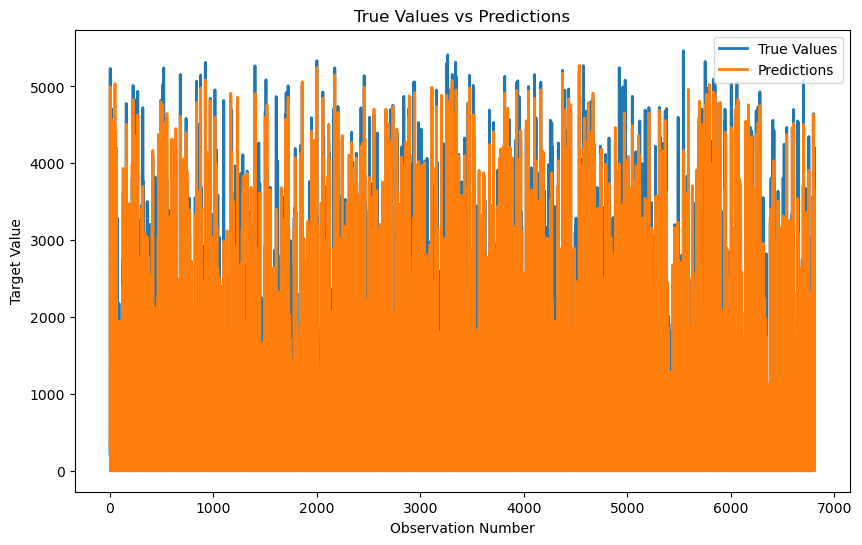

In [ ]:
#Diffrences in columns two dataframes


predictions = model_A.predict(X_test_A)

# Clip predictions
predictions = np.clip(predictions, 0, None)

print('MAE A:', mean_absolute_error(predictions, y_test_A))

plt.figure(figsize=(10, 6))
plt.plot(y_test_A.reset_index(drop=True), label='True Values', linewidth=2)
plt.plot(predictions, label='Predictions', linewidth=2)
plt.title('True Values vs Predictions')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [ ]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Best parameters found
# print("Best trial:")
# trial = study.best_trial
# print(f" Value: {trial.value}")
# print(" Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

